# Tidy Data

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 6
pd.options.display.max_columns = 6

# Tidy Data

> Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

If there's one maxim I can impart it's that your tools shouldn't get in the way of your analysis. Your problem is already difficult enough, don't let the data or your tools make it any harder.

## The Rules

In a tidy dataset...

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

We'll cover a few methods that help you get there.

Based on [this](http://stackoverflow.com/questions/22695680/python-pandas-timedelta-specific-rows) StackOverflow question.

I fetched some data

```python
tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2015_games.html")
games = tables[0]
games.to_csv('data/games.csv', index=False)
```

In [44]:
!head -n 2 data/games.csv

Date,Unnamed: 1,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Notes
"Tue, Oct 28, 2014",Box Score,Houston Rockets,108,Los Angeles Lakers,90,,


The Question:
> **How many days of rest did each team get between each game?**

Whether or not your dataset is tidy depends on your question. Given our question, what is an observation?

In [45]:
column_names = ['date', '_', 'away_team', 'away_points', 'home_team',
                'home_points', 'n_ot', 'notes']
games = (pd.read_csv('data/games.csv', names=column_names, parse_dates=['date'],
                     skiprows=1)
           .drop(['_', 'notes', 'n_ot'], axis='columns')
           .set_index('date', append=True))
games.index.names = ['game_id', 'date']
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108


Is `games` a tidy dataset, given our question? No, we have multiple observations (teams) per row. We'll use `pd.melt` to fix that.

In [48]:
tidy = pd.melt(games.sort_index().reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')

In [49]:
tidy.head()

,game_id,date,variable,team
0,0,2014-10-28,away_team,Houston Rockets
1,1,2014-10-28,away_team,Orlando Magic
2,2,2014-10-28,away_team,Dallas Mavericks
3,3,2014-10-29,away_team,Brooklyn Nets
4,4,2014-10-29,away_team,Milwaukee Bucks


Now the translation from question to operation is direct:

In [50]:
# For each team... get number of dates between games
tidy.groupby('team')['date'].diff().dt.days - 1

0      NaN
1      NaN
2      NaN
        ..
2457     4
2458     1
2459    10
dtype: float64

In [7]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().tail()

,game_id,date,variable,team,rest
2455,1225,2015-04-15,home_team,Minnesota Timberwolves,1
2456,1226,2015-04-15,home_team,New Orleans Pelicans,1
2457,1227,2015-04-15,home_team,New York Knicks,1
2458,1228,2015-04-15,home_team,Philadelphia 76ers,1
2459,1229,2015-04-15,home_team,Toronto Raptors,0


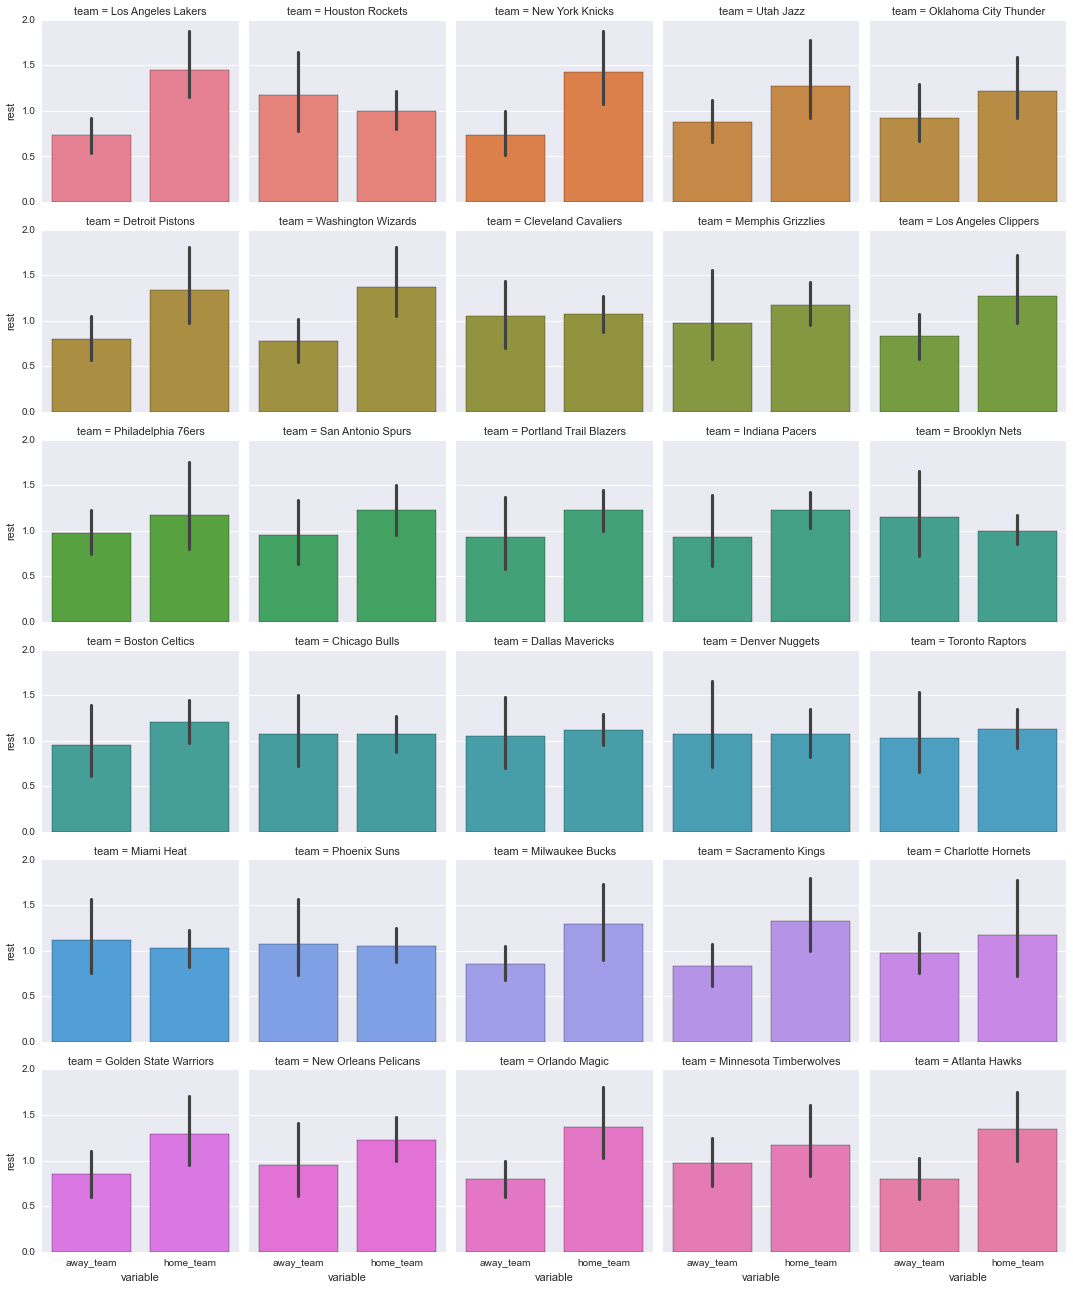

In [8]:
g = sns.FacetGrid(data=tidy.dropna(), col='team', col_wrap=5, hue='team')
g.map(sns.barplot, "variable", "rest");

What are we doing?

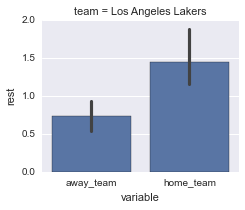

In [9]:
r = tidy.dropna()
r = r[r.team == 'Los Angeles Lakers']
g = sns.FacetGrid(data=r, col='team', col_wrap=5, hue='team')
g.map(sns.barplot, "variable", "rest");

In [10]:
g = r.groupby('variable')
g.rest.sum()/g.rest.count()

variable
away_team    0.731707
home_team    1.450000
Name: rest, dtype: float64

# Stack / Unstack

An "observation" depends on the question. Home team advantage?

('Home win percent:', 0.5747967479674797)


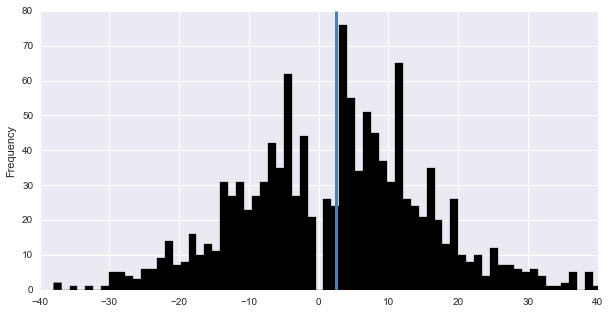

In [12]:
home_adv = games.home_points - games.away_points
ax = (home_adv).plot(kind='hist', bins=80, color='k', figsize=(10, 5))
ax.set_xlim(-40, 40)
mu = home_adv.mean()
ax.vlines(mu, *ax.get_ylim(), color='steelblue', linewidth=3)
print('Home win percent:', (home_adv > 0).mean())

# Team Strength

# Mini Project: Home Court Advantage?

What's the effect (in terms of probability to win) of being
the home team.

### Step 1: Calculate Win %

We need to create an indicator for whether the home team won.
Add it as a column called `home_win` in `games`.

In [14]:
games['home_win'] = games['home_points'] > games['away_points']
games.head()

,,away_team,away_points,home_team,home_points,home_win
game_id,date,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,False
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,True
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,True
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,True
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,True


### Step 2: Find the win percent for each team

Teams are split across two columns. It's easiest to calculate the number of wins and
number of games as away, and the number of wins and number of games as home. Then
combine those two results to get the win percent.

In [15]:
wins_as_away = games.groupby('away_team').home_win.agg(
    {'n_games': 'count', 'n_wins': lambda x: (~x).sum()}
)
wins_as_home = games.groupby('home_team').home_win.agg(
    {'n_games': 'count', 'n_wins': 'sum'}
)
wins = (wins_as_away + wins_as_home)
wins_as_home.columns = ['n_wins', 'n_games']
wins_as_away.columns = ['n_wins', 'n_games']

Now add `wins_as_home` and `wins_as_away` to get a DataFrame with
two columsn, `n_wins`, and `n_games` and one row per team.

Finally, calculate the win percent.

In [16]:
# Win percent
wins = (wins_as_away + wins_as_home)
strength = wins.n_wins / wins.n_games
strength.index.name = 'team'
strength.name = 'strength'

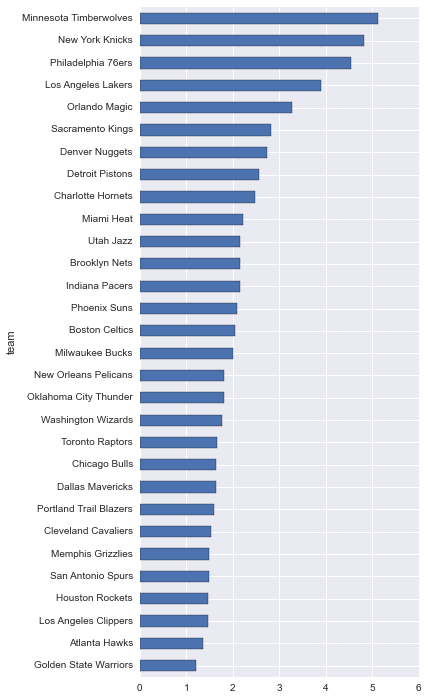

In [18]:
strength.sort_values().plot(kind='barh', figsize=(5, 12))

Bring the `strength` valuess in for each team, for each game.

In [19]:
games.head()

,,away_team,away_points,home_team,home_points,home_win
game_id,date,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,False
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,True
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,True
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,True
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,True


For SQL people

```sql
SELECT *
FROM games NATURAL JOIN strength
```

We just need to get the names worked out.

In [20]:
strength.head().reset_index().rename(columns=lambda x: 'away_' + x)

,away_team,away_strength
0,Atlanta Hawks,1.366667
1,Boston Celtics,2.050000
2,Brooklyn Nets,2.157895
3,Charlotte Hornets,2.484848
4,Chicago Bulls,1.640000


In [21]:
(pd.merge(games.reset_index(), strength.reset_index().add_prefix('away_'))
   .pipe(pd.merge, strength.reset_index().add_prefix('home_'))
   .set_index(['game_id', 'date']))

,,away_team,away_points,home_team,...,home_win,away_strength,home_strength
game_id,date,,,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,...,False,1.464286,3.904762
661,2015-01-25,Houston Rockets,99,Los Angeles Lakers,...,False,1.464286,3.904762
541,2015-01-09,Orlando Magic,84,Los Angeles Lakers,...,True,3.280000,3.904762
...,...,...,...,...,...,...,...,...
476,2014-12-31,Charlotte Hornets,83,Houston Rockets,...,True,2.484848,1.464286
380,2014-12-18,New Orleans Pelicans,99,Houston Rockets,...,False,1.822222,1.464286
1195,2015-04-12,New Orleans Pelicans,114,Houston Rockets,...,True,1.822222,1.464286


For python people

In [22]:
games = games.assign(away_strength=games.away_team.map(strength),
                     home_strength=games.home_team.map(strength))
games.head()

,,away_team,away_points,home_team,...,home_win,away_strength,home_strength
game_id,date,,,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,...,False,1.464286,3.904762
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,...,True,3.280000,1.822222
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,...,True,1.640000,1.490909
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,...,True,2.157895,2.050000
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,...,True,2.000000,2.484848


# Pivoting

In [33]:
tidy

,game_id,date,variable,team,rest
0,0,2014-10-28,away_team,Houston Rockets,NaN
1,1,2014-10-28,away_team,Orlando Magic,NaN
2,2,2014-10-28,away_team,Dallas Mavericks,NaN
...,...,...,...,...,...
2457,1227,2015-04-15,home_team,New York Knicks,1
2458,1228,2015-04-15,home_team,Philadelphia 76ers,1
2459,1229,2015-04-15,home_team,Toronto Raptors,0


In [31]:
un = pd.pivot_table(tidy, values='rest',
                    index=['game_id', 'date'],
                    columns='variable').rename(
    columns={'away_team': 'away_rest', 'home_team': 'home_rest'}
)
un.columns.name = None

In [32]:
un.dropna().head()

,,away_rest,home_rest
game_id,date,,
16,2014-10-30,0,1
18,2014-10-30,0,0
19,2014-10-30,0,1
20,2014-10-31,0,1
21,2014-10-31,1,1


In [34]:
df = pd.concat([games, un], axis=1)
df

,,away_team,away_points,home_team,...,home_strength,away_rest,home_rest
game_id,date,,,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,...,3.904762,NaN,NaN
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,...,1.822222,NaN,NaN
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,...,1.490909,NaN,NaN
...,...,...,...,...,...,...,...,...
1227,2015-04-15,Detroit Pistons,112,New York Knicks,...,4.823529,1,1
1228,2015-04-15,Miami Heat,105,Philadelphia 76ers,...,4.555556,1,1
1229,2015-04-15,Charlotte Hornets,87,Toronto Raptors,...,1.673469,1,0


In [35]:
X = pd.concat([games, un], axis=1).set_index(['away_team', 'home_team'], append=True).dropna()

In [36]:
X.head()

,,,,away_points,home_points,home_win,...,home_strength,away_rest,home_rest
game_id,date,away_team,home_team,,,,,,,
16,2014-10-30,Utah Jazz,Dallas Mavericks,102,120,True,...,1.640000,0,1
18,2014-10-30,Detroit Pistons,Minnesota Timberwolves,91,97,True,...,5.125000,0,0
19,2014-10-30,Washington Wizards,Orlando Magic,105,98,False,...,3.280000,0,1
20,2014-10-31,Cleveland Cavaliers,Chicago Bulls,114,108,False,...,1.640000,0,1
21,2014-10-31,Memphis Grizzlies,Indiana Pacers,97,89,False,...,2.157895,1,1


In [37]:
X['home_win'] = X.home_win.astype(int)  # for statsmodels

In [39]:
import statsmodels.api as sm

In [40]:
mod = sm.Logit.from_formula('home_win ~ home_strength + away_strength + home_rest + away_rest', X)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.581292
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                 1213
Model:                          Logit   Df Residuals:                     1208
Method:                           MLE   Df Model:                            4
Date:                Sat, 26 Sep 2015   Pseudo R-squ.:                  0.1482
Time:                        11:25:11   Log-Likelihood:                -705.11
converged:                       True   LL-Null:                       -827.83
                                        LLR p-value:                 6.248e-52
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         0.4197      0.234      1.790      0.073        -0.040     0.879
home_strength    -0.7929      0.073    -10.866      0.000        -0.936    -0.650
away_strength     0.7008      0.080      8.776      0.000         0.544     0.857
home_rest         0.1316      0.069      1.918      0.055        -0.003     0.266
away_rest        -0.0198      0.065     -0.304      0.761        -0.147     0.108
=================================================================================
"""

In [41]:
mod = sm.Logit.from_formula('home_win ~ rest_difference',
                            X.assign(rest_difference=lambda df: df.home_rest - df.away_rest))
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.682125
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                 1213
Model:                          Logit   Df Residuals:                     1211
Method:                           MLE   Df Model:                            1
Date:                Sat, 26 Sep 2015   Pseudo R-squ.:               0.0004950
Time:                        11:25:21   Log-Likelihood:                -827.42
converged:                       True   LL-Null:                       -827.83
                                        LLR p-value:                    0.3653
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.2815      0.060      4.721      0.000         0.165     0.398
rest_difference     0.0473      0.052      0.903      0.366        -0.055     0.150
===================================================================================
"""

In [42]:
mod = sm.OLS.from_formula('spread ~ home_strength + away_strength + rest_difference',
                            X.assign(rest_difference=lambda df: df.home_rest - df.away_rest,
                                     spread=lambda df: df.home_points - df.away_points))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 spread   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     104.5
Date:                Sat, 26 Sep 2015   Prob (F-statistic):           3.88e-60
Time:                        11:26:07   Log-Likelihood:                -4735.7
No. Observations:                1213   AIC:                             9479.
Df Residuals:                    1209   BIC:                             9500.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           3.4827      1.171      2.975      0.003         1.186     5.779
home_strength      -4.3927      0.336    -13.069      0.000        -5.052    -3.733
away_strength       3.8626      0.338     11.425      0.000         3.199     4.526
rest_difference     0.5875      0.310      1.896      0.058        -0.021     1.195
==============================================================================
Omnibus:                        6.266   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.858
Skew:                           0.107   Prob(JB):                       0.0324
Kurtosis:                       3.300   Cond. No.                         12.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Recap

- Tidy data: one row per observation
    - melt / stack: wide to long
    - pivot_table / unstack: long to wide